# Change Detection

Notebook created by [Herrera-Giménez, Marc](https://www.linkedin.com/in/marc-herrera/) and [Alonso-González, Alberto](https://www.linkedin.com/in/alberto-alonso-gonz%C3%A1lez-b9b07684/) for the Artificial Intelligence and Big Data for Earth Observation Course [AI4EO](https://www.upc.edu/content/grau/guiadocent/pdf/ang/230743) in the [ETSETB UPC](https://telecos.upc.edu/ca) (2025).

<hr>

## Introduction

We will start by importing and installing the necessary libraries to work with this data and to make the supervised classification.

In [ ]:
!pip install rasterio
import rasterio

import re

import numpy as np
import pandas as pd
import xarray as xr
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm

from google.colab import drive

from itertools import product

### Auxiliar Functions

We will define some auxiliar functions to plot the images (`plot_data`) and to plot the land cover information according to original ESA [WorldCover colors](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200) (`plot_landcover`)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [ ]:
def plot_data(data, title="", colorbar=False, **kwargs):
  """
  Plot some specific data
  """
  plt.figure(figsize=(12,6))
  img = plt.imshow(data, **kwargs)
  plt.title(title)
  if colorbar:
      plt.colorbar(img)
  plt.tight_layout()
  plt.show()

In [ ]:
def plot_landcover(land_cover_data, ax=None, figsize=(12, 6), title='ESA WorldCover Land Cover Classification',
                        legend_type='patches', legend_position='lower right', dpi=100):
    """
    Plot ESA WorldCover land cover data with class names instead of numerical codes.

    Parameters:
    -----------
    land_cover_data : numpy.ndarray
        2D array containing the ESA WorldCover land cover classification values
    figsize : tuple, optional
        Figure size (width, height) in inches
    title : str, optional
        Title for the plot
    legend_type : str, optional
        Type of legend to use: 'colorbar' or 'patches'
    legend_position : str, optional
        Position of the legend: 'right', 'bottom', 'left', or 'top'
    dpi : int, optional
        Resolution of the figure

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the plot
    ax : matplotlib.axes.Axes
        The axes object containing the plot
    """

    # ESA WorldCover standard colors (official colormap)
    esa_colors = {
        0: '#282828',   # Not Defined (dark gray)
        10: '#006400',  # Tree cover (dark green)
        20: '#FFBB22',  # Shrubland (orange)
        30: '#FFFF4C',  # Grassland (yellow)
        40: '#F096FF',  # Cropland (pink)
        50: '#FA0000',  # Built-up (red)
        60: '#B4B4B4',  # Bare/sparse vegetation (light gray)
        70: '#F0F0F0',  # Snow and ice (white)
        80: '#0064C8',  # Permanent water bodies (blue)
        90: '#0096A0',  # Herbaceous wetland (teal)
        95: '#00CF75',  # Mangroves (light green)
        100: '#FAE6A0'  # Moss and lichen (beige)
    }

    # Get unique classes in sorted order (excluding NaN)
    unique_classes = np.unique(land_cover_data)
    unique_classes = unique_classes[~np.isnan(unique_classes)]  # Remove NaN values
    unique_classes = np.sort(unique_classes)

    if ax is None:
        # Create figure and axis
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    else:
        # Get the figure
        fig = ax.figure


    # Prepare masked data to handle NaN values
    masked_data = np.ma.masked_invalid(land_cover_data)

    if legend_type == 'colorbar':
        # Create class boundaries for the colormap
        bounds = np.concatenate([unique_classes - 2.5, [unique_classes[-1] + 2.5]])

        # Create color list for the classes present in the data
        colors = [esa_colors[int(cls)] for cls in unique_classes if int(cls) in esa_colors]
        cmap = ListedColormap(colors)
        norm = BoundaryNorm(bounds, cmap.N)

        # Plot the data
        im = ax.imshow(masked_data, cmap=cmap, norm=norm)

        # Create the colorbar with class names
        cbar = fig.colorbar(im, ax=ax, orientation='vertical' if legend_position in ['right', 'left'] else 'horizontal')
        cbar.set_ticks(unique_classes)
        cbar.ax.set_yticklabels([class_mapping[int(cls)] for cls in unique_classes]) if legend_position in ['right', 'left'] else \
        cbar.ax.set_xticklabels([class_mapping[int(cls)] for cls in unique_classes], rotation=45, ha='right')

    else:  # legend_type == 'patches'
        # Create color list for the classes present in the data
        colors = [esa_colors[int(cls)] for cls in unique_classes if int(cls) in esa_colors]
        cmap = ListedColormap(colors)

        # Create normalized colormap with values mapped directly to colors
        bounds = np.concatenate([unique_classes - 2.5, [unique_classes[-1] + 2.5]])
        norm = BoundaryNorm(bounds, cmap.N)

        # Plot the data
        im = ax.imshow(masked_data, cmap=cmap, norm=norm)

        # Create legend patches
        legend_patches = [mpatches.Patch(color=esa_colors[int(cls)],
                                         label=f"{int(cls)}: {class_mapping[int(cls)]}")
                          for cls in unique_classes if int(cls) in esa_colors]

        # Add the legend
        ax.legend(handles=legend_patches, loc=legend_position, framealpha=0.7)
    # Set title and remove axes
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    #plt.tight_layout()

    return fig, ax

## Data

The data is uploaded and available in the user Google Drive, we will mount into the Colab the work space and the specific folder.

In [ ]:
drive.mount('/content/drive')
folder = '/content/drive/MyDrive/AI4EO Laboratory/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Load and analyse the data

The first step is to load and visualize the data in the stack to ensure proper loading and format.

In [ ]:
dataset_name = "Palma_datastack_change_detection.nc"
fullpath = folder + dataset_name

fire_datastack = xr.open_dataset(fullpath)
print(fire_datastack.data_vars)

Data variables:
    Amplitude_VV_20210823     (lat, lon) float32 3MB ...
    Amplitude_VV_20220108     (lat, lon) float32 3MB ...
    Amplitude_VH_20210823     (lat, lon) float32 3MB ...
    Amplitude_VH_20220108     (lat, lon) float32 3MB ...
    VH_VV_rate_20210823       (lat, lon) float32 3MB ...
    VH_VV_rate_20220108       (lat, lon) float32 3MB ...
    Sigma_Nought_VH_20210823  (lat, lon) float32 3MB ...
    Sigma_Nought_VH_20220108  (lat, lon) float32 3MB ...
    RVI_20210823              (lat, lon) float32 3MB ...
    RVI_20220108              (lat, lon) float32 3MB ...
    RWI_20210823              (lat, lon) float32 3MB ...
    RWI_20220108              (lat, lon) float32 3MB ...
    MPDI_20210823             (lat, lon) float32 3MB ...
    MPDI_20220108             (lat, lon) float32 3MB ...
    S2_Red_20210826           (lat, lon) float32 3MB ...
    S2_Green_20210826         (lat, lon) float32 3MB ...
    S2_Blue_20210826          (lat, lon) float32 3MB ...
    S2_Red_2022

[ 0. 10. 20. 30. 40. 50. 60. 80.]
[ 0. 10. 20. 30. 40. 50. 60. 80.]


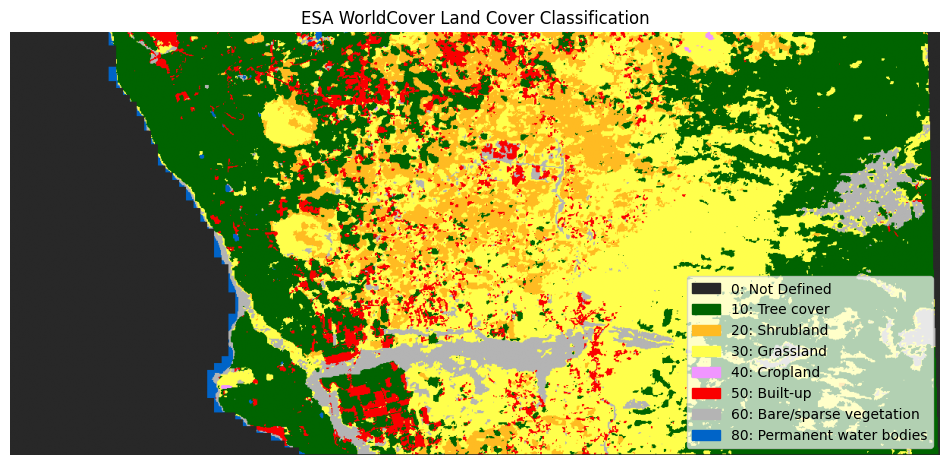

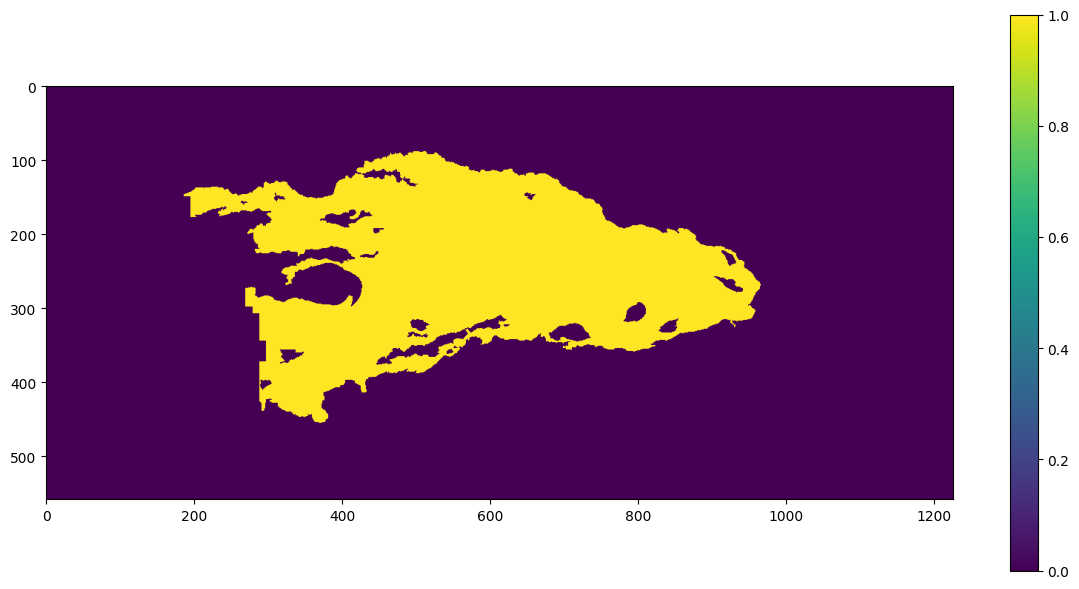

In [ ]:
LC_class_names = [
    'Tree cover',
    'Shrubland',
    'Grassland',
    'Cropland',
    'Built-up',
    'Bare / sparse vegetation',
    'Snow and ice',
    'Permanent water bodies',
    'Herbaceous wetland',
    'Mangroves',
    'Moss and lichen'
]

class_mapping = {
    0: "Not Defined",
    10: "Tree cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare/sparse vegetation",
    70: "Snow and ice",
    80: "Permanent water bodies",
    90: "Herbaceous wetland",
    95: "Mangroves",
    100: "Moss and lichen"
}

print(np.unique(fire_datastack.Land_Cover.values))
fire_datastack["Land_Cover"] = fire_datastack["Land_Cover"].where(fire_datastack["Land_Cover"] != 255).fillna(0)
fire_datastack["Change_Band"] = fire_datastack["Change_Band"].where(fire_datastack["Change_Band"] != 255).fillna(0)
fire_datastack["Change_Band"] = fire_datastack["Change_Band"].where(fire_datastack["Change_Band"] == 0, 1)

print(np.unique(fire_datastack.Land_Cover.values))
land_cover_layer = fire_datastack.Land_Cover
Change_Band_layer = fire_datastack.Change_Band

fig, ax = plot_landcover(fire_datastack.Land_Cover.values)
plt.show()
plot_data(Change_Band_layer, colorbar = True)

## Optical RGB Images

Here we will plot the RGB optical images for the three dates. Let's try to visualise the changes and differences in the scene.

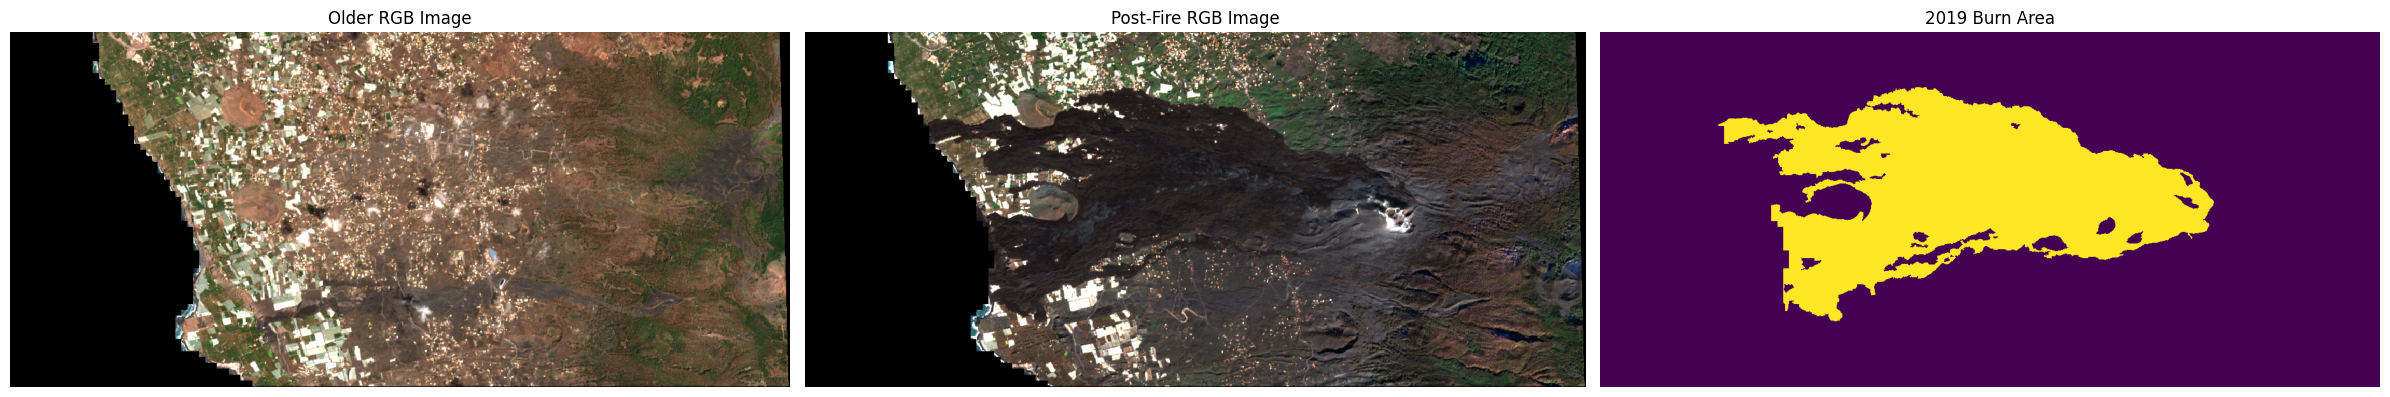

In [ ]:
rgb_20210826 = np.dstack((fire_datastack.S2_Red_20210826, fire_datastack.S2_Green_20210826, fire_datastack.S2_Blue_20210826))
rgb_20210826 = rgb_20210826 / np.nanpercentile(rgb_20210826, 98)
rgb_20210826 = np.clip(rgb_20210826, 0, 1)

rgb_20210826 = np.dstack((fire_datastack.S2_Red_20210826, fire_datastack.S2_Green_20210826, fire_datastack.S2_Blue_20210826))
rgb_20210826 = rgb_20210826 / np.nanpercentile(rgb_20210826, 98)
rgb_20210826 = np.clip(rgb_20210826, 0, 1)

rgb_20220103 = np.dstack((fire_datastack.S2_Red_20220103, fire_datastack.S2_Green_20220103, fire_datastack.S2_Blue_20220103))
rgb_20220103 = rgb_20220103 / np.nanpercentile(rgb_20220103, 98)
rgb_20220103 = np.clip(rgb_20220103, 0, 1)


fig, ax = plt.subplots(1, 3, figsize=(24, 48))

ax[0].imshow(rgb_20210826)
ax[0].set_title("Older RGB Image")
ax[0].axis('off')


ax[1].imshow(rgb_20220103)
ax[1].set_title("Post-Fire RGB Image")
ax[1].axis('off')

ax[2].imshow(fire_datastack.Change_Band)
ax[2].set_title("2019 Burn Area")
ax[2].axis('off')

plt.tight_layout()
plt.show()

 * Can you spot the differences corresponding to the Burn Area map? green -> brown
 * Can you spot some other differences not present on the map?

## SAR RGB Images

Here we will visualize the RGB composites from SAR data for the three dates.
Remember that since we have only 2 channels in SAR (VV and VH amplitudes) we build the third channel as the ratio between them (VV/VH)

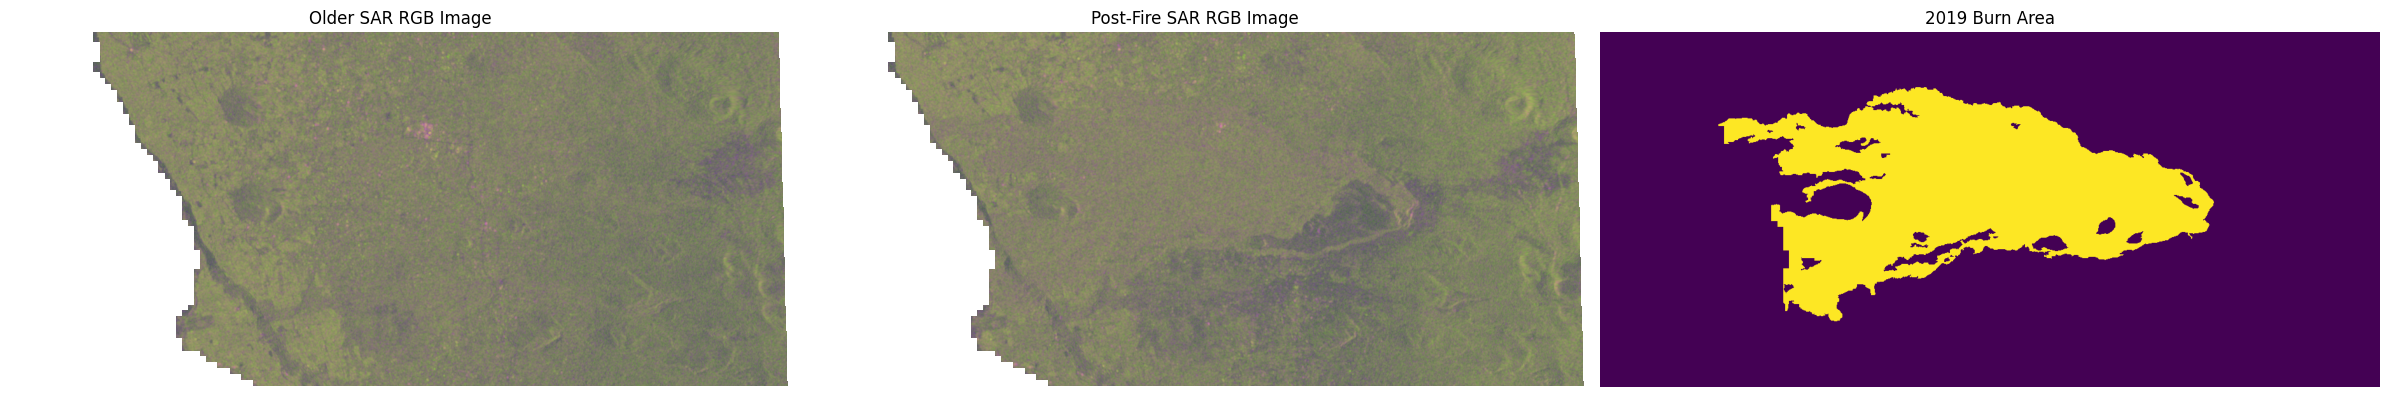

In [ ]:
rgb_SAR_data_S1_20210823 = np.dstack((fire_datastack.Amplitude_VV_20210823, fire_datastack.Amplitude_VH_20210823, fire_datastack.Amplitude_VV_20210823 / fire_datastack.Amplitude_VH_20210823 ))
#rgb_SAR_data_S1_20210823 = fire_datastack.Amplitude_VV_20210823 / fire_datastack.Amplitude_VH_20210823
rgb_SAR_data_S1_20210823 = rgb_SAR_data_S1_20210823 / (2.5*np.nanmean(rgb_SAR_data_S1_20210823, axis=(0,1)))
rgb_SAR_data_S1_20210823 = np.clip(rgb_SAR_data_S1_20210823, 0, 1)

rgb_SAR_data_S1_20210823 = np.dstack((fire_datastack.Amplitude_VV_20210823, fire_datastack.Amplitude_VH_20210823, fire_datastack.Amplitude_VV_20210823 / fire_datastack.Amplitude_VH_20210823 ))
#rgb_SAR_data_S1_20210823 = fire_datastack.Amplitude_VV_20210823 / fire_datastack.Amplitude_VH_20210823
rgb_SAR_data_S1_20210823 = rgb_SAR_data_S1_20210823 / (2.5*np.nanmean(rgb_SAR_data_S1_20210823, axis=(0,1)))
rgb_SAR_data_S1_20210823 = np.clip(rgb_SAR_data_S1_20210823, 0, 1)

rgb_SAR_data_S1_20220108 = np.dstack((fire_datastack.Amplitude_VV_20220108, fire_datastack.Amplitude_VH_20220108, fire_datastack.Amplitude_VV_20220108 / fire_datastack.Amplitude_VH_20220108 ))
#rgb_SAR_data_S1_20220108 = fire_datastack.Amplitude_VV_20220108 / fire_datastack.Amplitude_VH_20220108
rgb_SAR_data_S1_20220108 = rgb_SAR_data_S1_20220108 / (2.5*np.nanmean(rgb_SAR_data_S1_20220108, axis=(0,1)))
rgb_SAR_data_S1_20220108 = np.clip(rgb_SAR_data_S1_20220108, 0, 1)

fig, ax = plt.subplots(1, 3, figsize=(24, 48))

ax[0].imshow(rgb_SAR_data_S1_20210823)
ax[0].set_title("Older SAR RGB Image")
ax[0].axis('off')

ax[1].imshow(rgb_SAR_data_S1_20220108)
ax[1].set_title("Post-Fire SAR RGB Image")
ax[1].axis('off')

ax[2].imshow(fire_datastack.Change_Band)
ax[2].set_title("2019 Burn Area")
ax[2].axis('off')

plt.tight_layout()
plt.show()

 * Can you spot the differences corresponding to the Burn Area map?
 * In which channel are the differences more visible? VV/VH

## Temporal RGB Images

A false color RGB may be generated by combining the same band in different dates for each RGB channel.

If there is no change everything will appear in grayscale, as all the three channels will be equal. When some change occurs colors will start to appear, depending on the date.

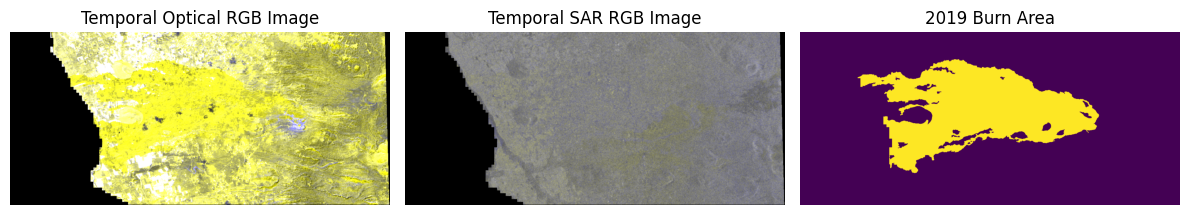

In [ ]:
temporal_rgb = np.dstack((fire_datastack.S2_Green_20210826, fire_datastack.S2_Green_20210826, fire_datastack.S2_Green_20220103))
temporal_rgb = temporal_rgb / np.nanpercentile(temporal_rgb, 75)
temporal_rgb = np.clip(temporal_rgb, 0, 1)

temporal_sar_rgb = np.dstack((fire_datastack.Amplitude_VH_20210823, fire_datastack.Amplitude_VH_20210823, fire_datastack.Amplitude_VH_20220108))
temporal_sar_rgb = temporal_sar_rgb / (2.5*np.nanmean(temporal_sar_rgb))
#temporal_sar_rgb = temporal_sar_rgb / np.nanpercentile(temporal_sar_rgb,98)
temporal_sar_rgb = np.clip(temporal_sar_rgb, 0, 1)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(temporal_rgb)
ax[0].set_title("Temporal Optical RGB Image")
ax[0].axis('off')

ax[1].imshow(temporal_sar_rgb)
ax[1].set_title("Temporal SAR RGB Image")
ax[1].axis('off')

ax[2].imshow(fire_datastack.Change_Band)
ax[2].set_title("2019 Burn Area")
ax[2].axis('off')

plt.tight_layout()
plt.show()

 * Can you spot the differences corresponding to the Burn Area map?
 * Can you spot some other differences not present on the map?
 * Do different changes appear in different colors?

## Differences

Here we will analyze quantitatively the difference between two dates.

For this, distances or similarity measures may be used.
Here we will try the [cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity) and the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance).

Note that these measures can be applied to an arbitrary number of bands.

### Differences in optical data

In [ ]:
def pixelwise_cosine_similarity(img1, img2):
    h, w, c = img1.shape

    flat1 = img1.reshape(-1, c)
    flat2 = img2.reshape(-1, c)

    valid_mask = ~np.isnan(flat1).any(axis=1) & ~np.isnan(flat2).any(axis=1)

    similarities = np.full(flat1.shape[0], np.nan)

    similarities[valid_mask] = np.einsum('ij,ij->i', flat1[valid_mask], flat2[valid_mask]) / (
        np.linalg.norm(flat1[valid_mask], axis=1) * np.linalg.norm(flat2[valid_mask], axis=1)
    )

    return similarities.reshape(h, w)

def pixelwise_euclidean_distance(img1, img2):
    diff = img1 - img2
    dist = np.linalg.norm(diff, axis=2)
    return dist

dv_2017 = np.dstack((fire_datastack.S2_Red_20210826, fire_datastack.S2_Green_20210826, fire_datastack.S2_Blue_20210826))
dv_2019_pre = np.dstack((fire_datastack.S2_Red_20210826, fire_datastack.S2_Green_20210826, fire_datastack.S2_Blue_20210826))
dv_2019_post = np.dstack((fire_datastack.S2_Red_20220103, fire_datastack.S2_Green_20220103, fire_datastack.S2_Blue_20220103))

cosmap_2017_2019pre = pixelwise_cosine_similarity(dv_2017, dv_2019_pre)
cosmap_2019pre_2019post = pixelwise_cosine_similarity(dv_2019_pre, dv_2019_post)


euclid_diff_2017_2019pre = pixelwise_euclidean_distance(dv_2017, dv_2019_pre)
euclid_diff_2019pre_2019post = pixelwise_euclidean_distance(dv_2019_pre, dv_2019_post)

dissim_2017_2019pre = 1 - cosmap_2017_2019pre
dissim_2019pre_2019post = 1 - cosmap_2019pre_2019post

# Clean memory
dv_2017 = dv_2019_pre = dv_2019_post = None
cosmap_2017_2019pre = cosmap_2019pre_2019post = None

<ipython-input-50-35f4c9b41332>:11: RuntimeWarning: invalid value encountered in divide
  similarities[valid_mask] = np.einsum('ij,ij->i', flat1[valid_mask], flat2[valid_mask]) / (


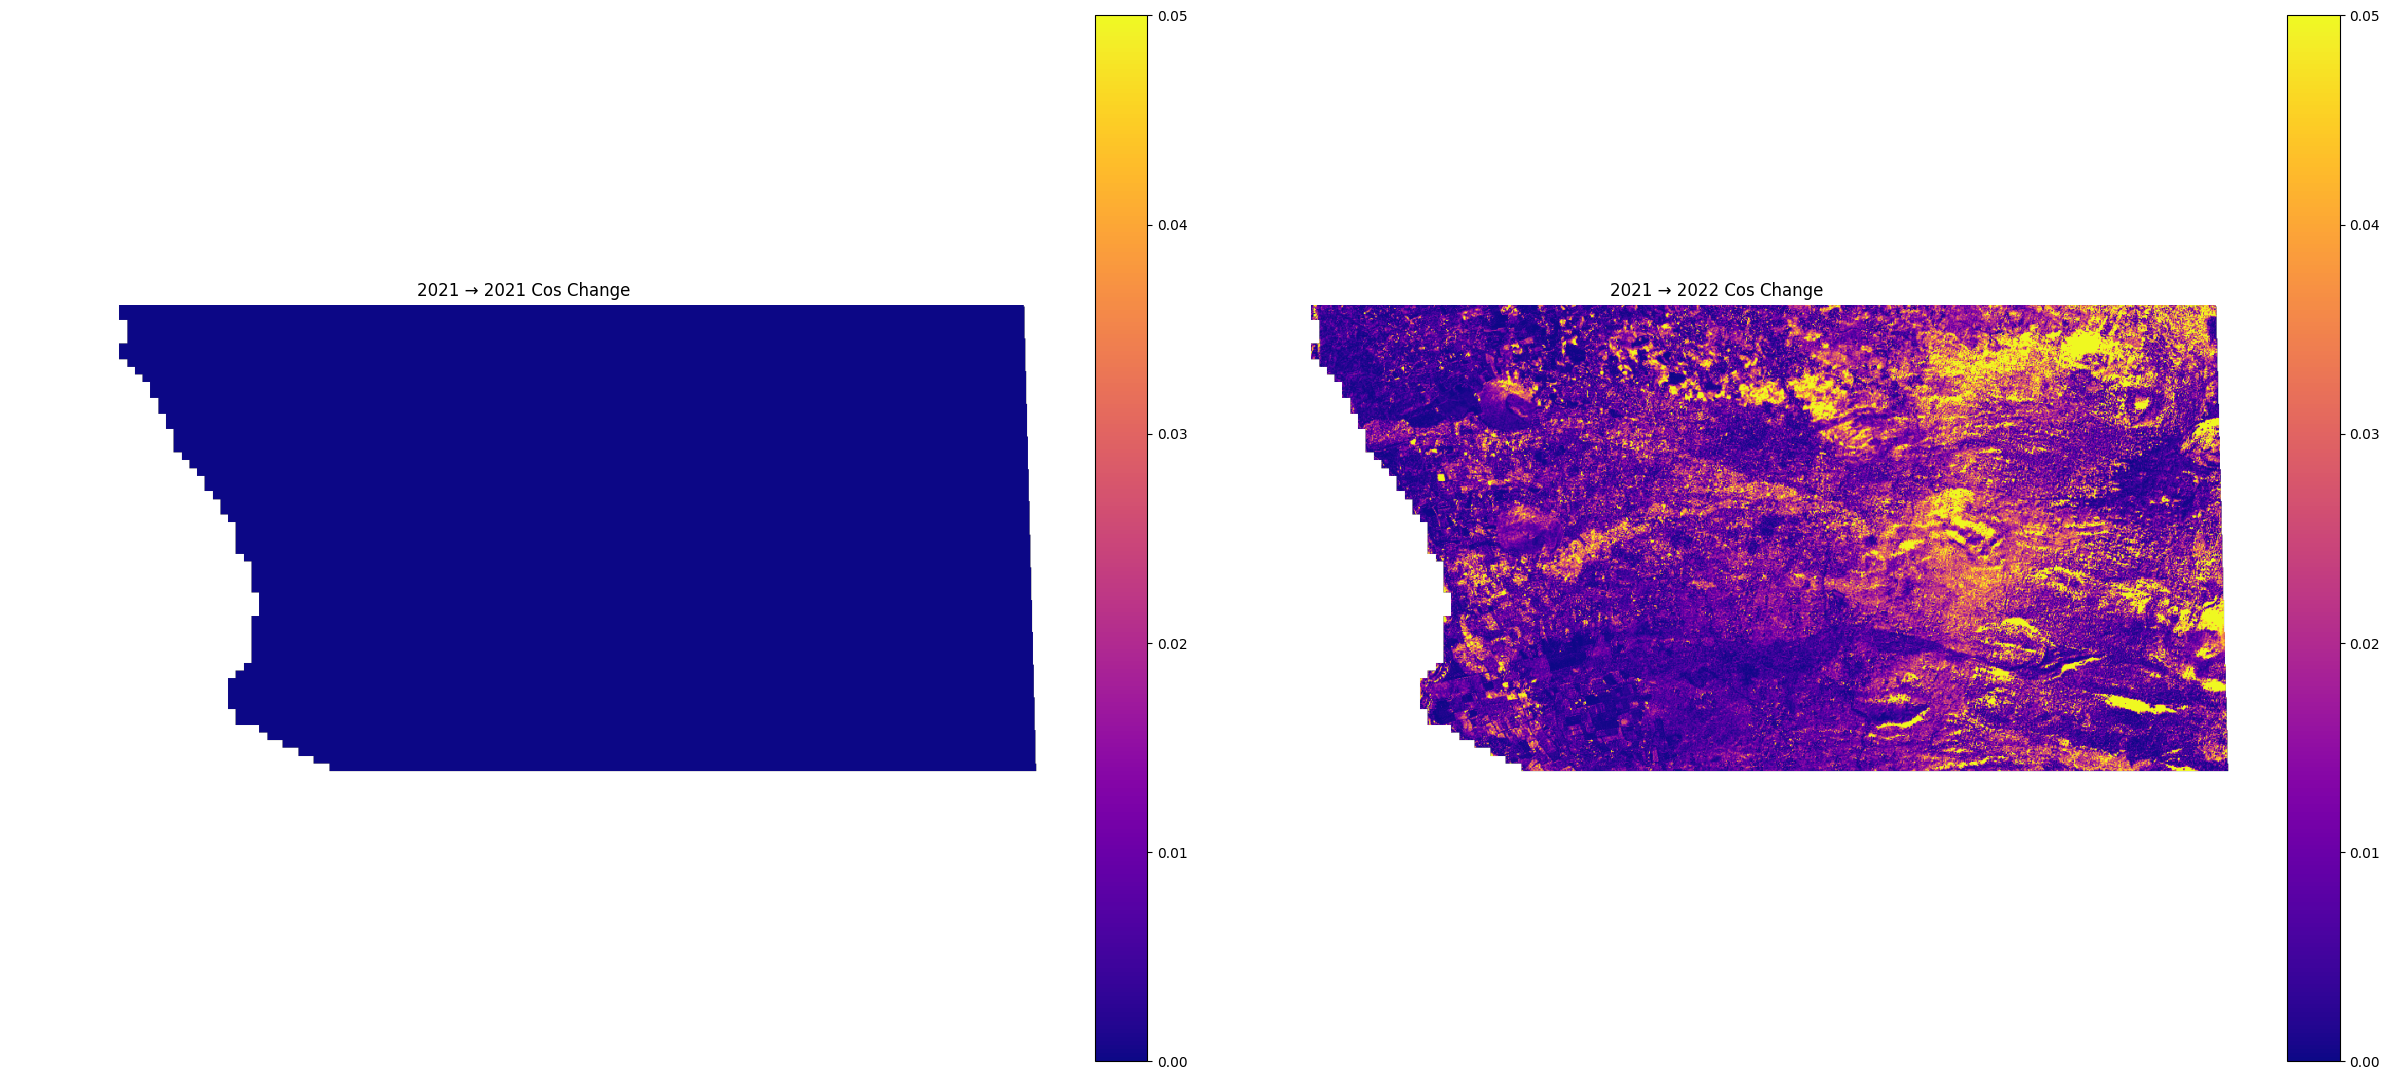

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 48))

im1 = ax[0].imshow(dissim_2017_2019pre, cmap='plasma', vmin=0, vmax=0.05)
ax[0].set_title("2021 → 2021 Cos Change")
ax[0].axis('off')
plt.colorbar(im1, ax=ax[0], fraction=0.046)

im2 = ax[1].imshow(dissim_2019pre_2019post, cmap='plasma', vmin=0, vmax=0.05)
ax[1].set_title("2021 → 2022 Cos Change")
ax[1].axis('off')
plt.colorbar(im2, ax=ax[1], fraction=0.046)

plt.tight_layout()
plt.show()

 * Can you spot the differences corresponding to the Burn Area map?
 * Which other changes appear very visible? Why? Noise in dark areas

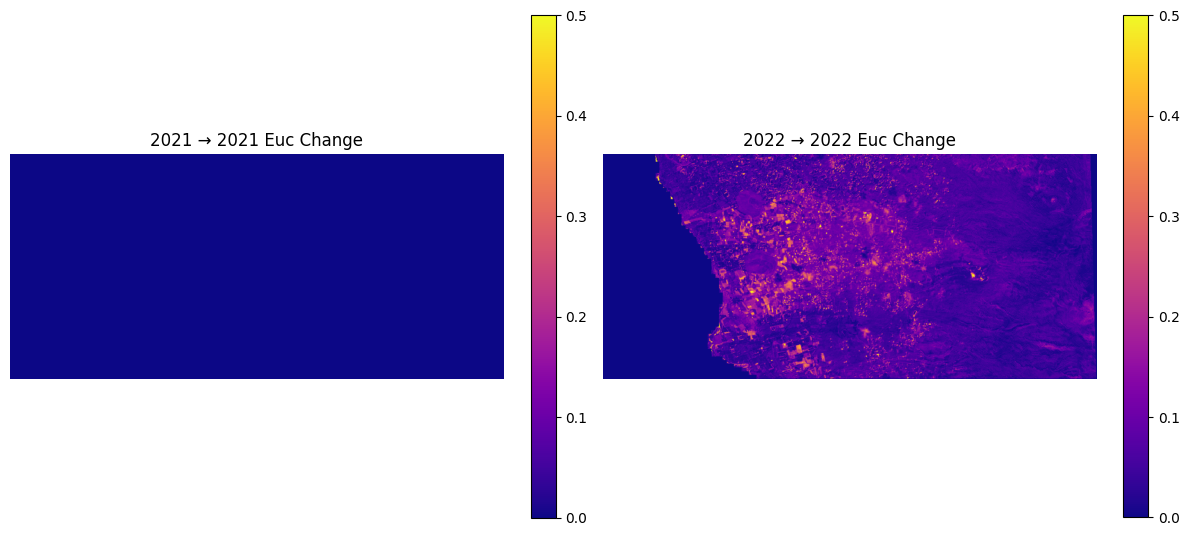

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

im1 = ax[0].imshow(euclid_diff_2017_2019pre, cmap='plasma', vmax=0.5)
ax[0].set_title("2021 → 2021 Euc Change")
ax[0].axis('off')
plt.colorbar(im1, ax=ax[0], fraction=0.046)

im2 = ax[1].imshow(euclid_diff_2019pre_2019post, cmap='plasma', vmax=0.5)
ax[1].set_title("2022 → 2022 Euc Change")
ax[1].axis('off')
plt.colorbar(im2, ax=ax[1], fraction=0.046)

plt.tight_layout()
plt.show()

 * Can you spot the differences corresponding to the Burn Area map?
 * Why some strong changes in cosine distance do not appear here?
 dissim_2017_2019pre = 1 - cosmap_2017_2019pre
 dissim_2019pre_2019post = 1 - cosmap_2019pre_2019post

### Differences in SAR data

For SAR data the amplitude ratio is normally used for change detection.
Here the `10*log10(ratio)` (dBs) will be used to show also the increase or decrease as positive or negative values.
The pixels that do not change will appear with a value close to 0.

<ipython-input-53-67d053f8db49>:7: RuntimeWarning: invalid value encountered in divide
  SAR_RGB_ratio_2017pre_2019post = 10*np.log10(rgb_SAR_data_S1_20210823 / rgb_SAR_data_S1_20210823)
<ipython-input-53-67d053f8db49>:8: RuntimeWarning: invalid value encountered in divide
  SAR_RGB_ratio_2019pre_2019post = 10*np.log10(rgb_SAR_data_S1_20210823 / rgb_SAR_data_S1_20220108)


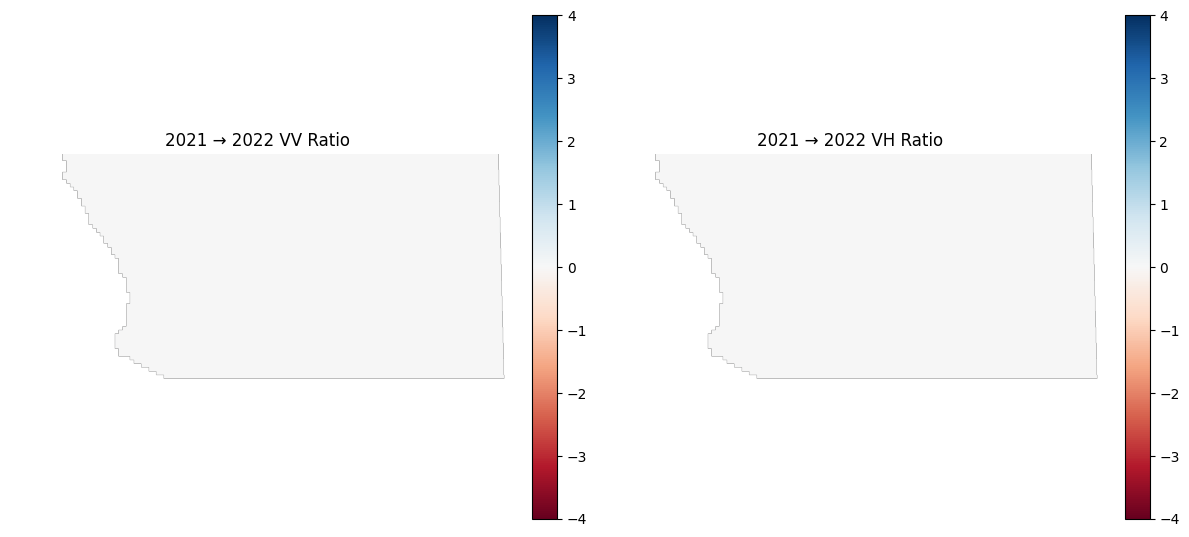

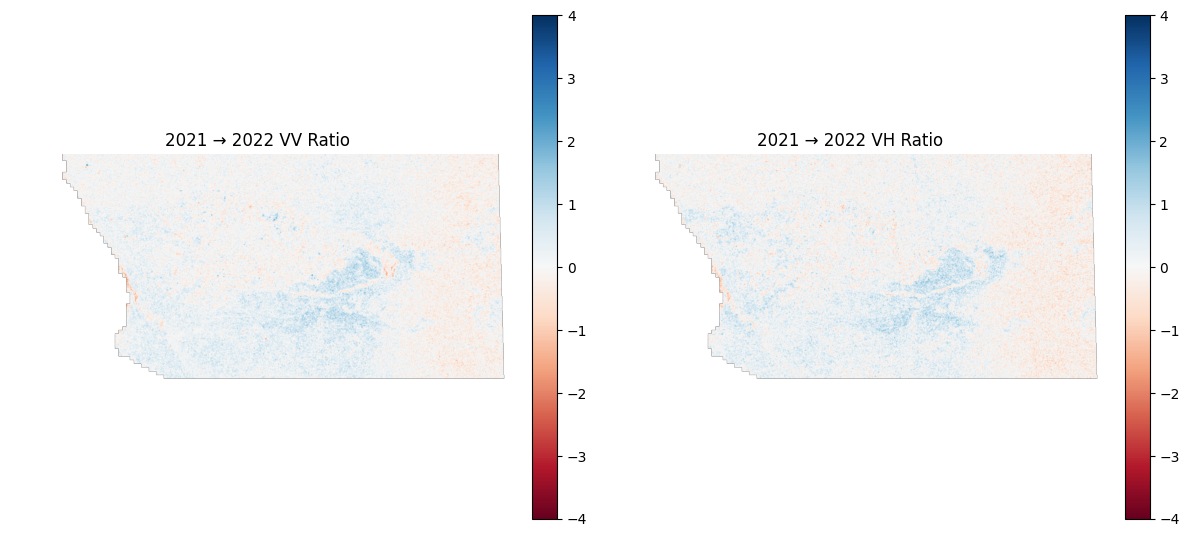

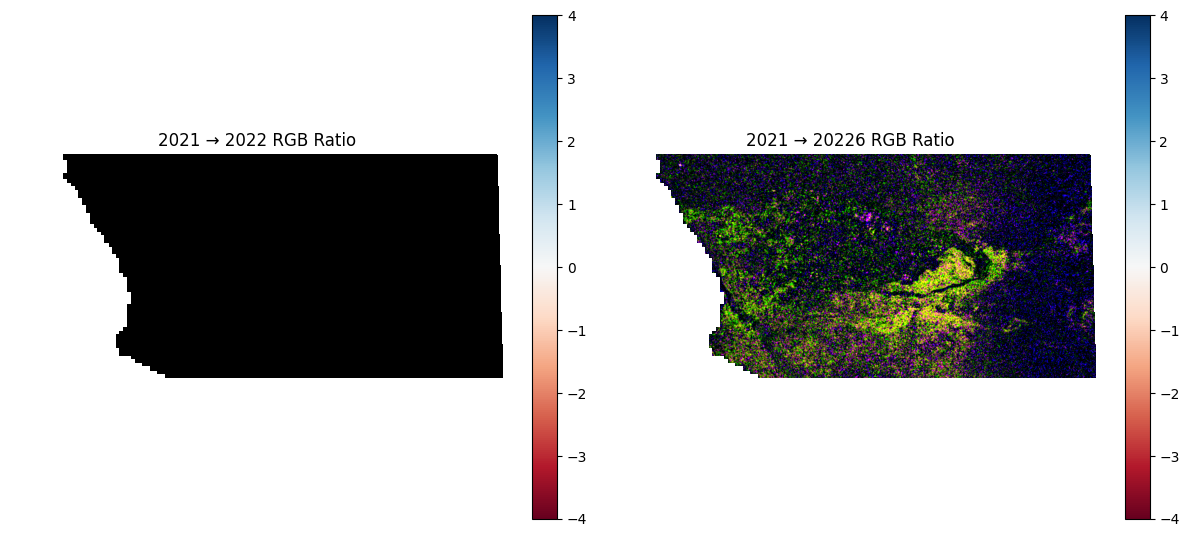

In [ ]:
SAR_VV_ratio_2017_2019pre = 10*np.log10(fire_datastack.Amplitude_VV_20210823 / fire_datastack.Amplitude_VV_20210823)
SAR_VH_ratio_2017_2019pre = 10*np.log10(fire_datastack.Amplitude_VH_20210823 / fire_datastack.Amplitude_VH_20210823)

SAR_VV_ratio_2019pre_2019post = 10*np.log10(fire_datastack.Amplitude_VV_20210823 / fire_datastack.Amplitude_VV_20220108)
SAR_VH_ratio_2019pre_2019post = 10*np.log10(fire_datastack.Amplitude_VH_20210823 / fire_datastack.Amplitude_VH_20220108)

SAR_RGB_ratio_2017pre_2019post = 10*np.log10(rgb_SAR_data_S1_20210823 / rgb_SAR_data_S1_20210823)
SAR_RGB_ratio_2019pre_2019post = 10*np.log10(rgb_SAR_data_S1_20210823 / rgb_SAR_data_S1_20220108)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

im1 = ax[0].imshow(SAR_VV_ratio_2017_2019pre, cmap='RdBu', vmin=-4, vmax=4)
ax[0].set_title("2021 → 2022 VV Ratio")
ax[0].axis('off')
plt.colorbar(im1, ax=ax[0], fraction=0.046)

im2 = ax[1].imshow(SAR_VH_ratio_2017_2019pre, cmap='RdBu', vmin=-4, vmax=4)
ax[1].set_title("2021 → 2022 VH Ratio")
ax[1].axis('off')
plt.colorbar(im2, ax=ax[1], fraction=0.046)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

im1 = ax[0].imshow(SAR_VV_ratio_2019pre_2019post, cmap='RdBu', vmin=-4, vmax=4)
ax[0].set_title("2021 → 2022 VV Ratio")
ax[0].axis('off')
plt.colorbar(im1, ax=ax[0], fraction=0.046)

im2 = ax[1].imshow(SAR_VH_ratio_2019pre_2019post, cmap='RdBu', vmin=-4, vmax=4)
ax[1].set_title("2021 → 2022 VH Ratio")
ax[1].axis('off')
plt.colorbar(im2, ax=ax[1], fraction=0.046)

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

im1 = ax[0].imshow(SAR_RGB_ratio_2017pre_2019post, cmap='RdBu', vmin=-4, vmax=4)
ax[0].set_title("2021 → 2022 RGB Ratio")
ax[0].axis('off')
plt.colorbar(im1, ax=ax[0], fraction=0.046)

im2 = ax[1].imshow(SAR_RGB_ratio_2019pre_2019post, cmap='RdBu', vmin=-4, vmax=4)
ax[1].set_title("2021 → 20226 RGB Ratio")
ax[1].axis('off')
plt.colorbar(im2, ax=ax[1], fraction=0.046)

plt.tight_layout()
plt.show()

 * Which changes are more visible? Burned area
 * The changes according to the Burned Area appear more visible in which band? Why? VH

We can also apply the ratio to the generated SAR RGBs

<ipython-input-54-2ee7b1422ac8>:1: RuntimeWarning: invalid value encountered in divide
  RGB_SAR_ratio_2017_2019post = rgb_20210826 / rgb_20220103


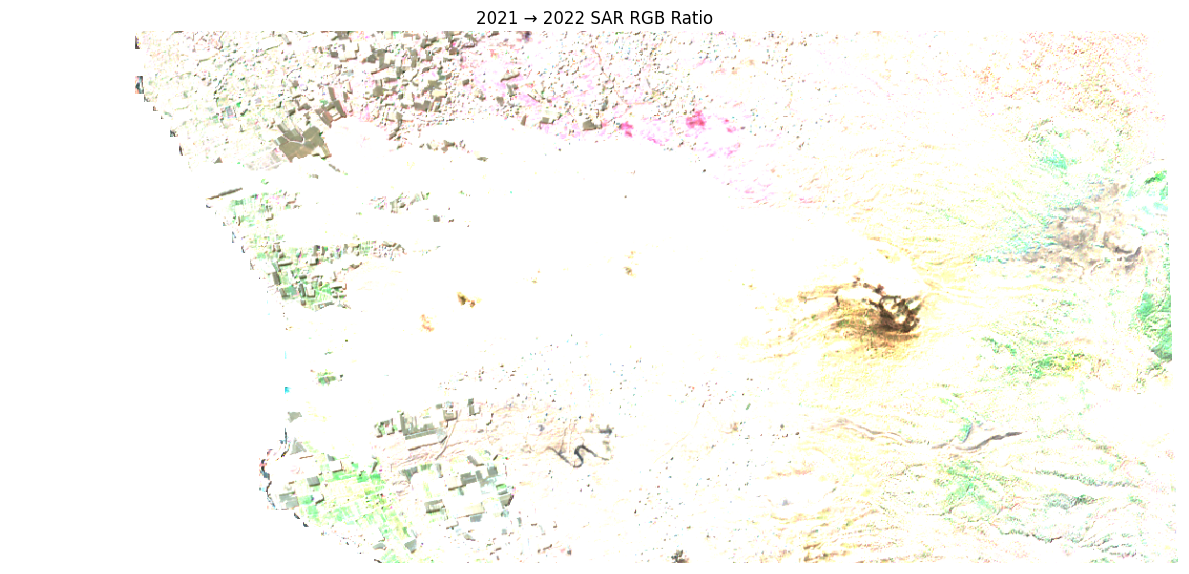

In [ ]:
RGB_SAR_ratio_2017_2019post = rgb_20210826 / rgb_20220103

plt.figure(figsize=(12, 24))
im = plt.imshow(RGB_SAR_ratio_2017_2019post)
plt.title("2021 → 2022 SAR RGB Ratio")
plt.axis('off')
plt.tight_layout()

plt.show()

## Land Cover Prediction

Using the Penedes dataset used in the previous lab session we can train a ML model to predict Land Cover and use it in each of our images to see how the model predicts depending on the changes occured on the scene.

We can also add some indices to our dataset by adding more bands as a combination of existing bands.
For instance the Radar Vegetation Index (RVI).

In [ ]:
# Add indices to dataset
# MPDI
#fire_datastack["MPDI_20210823"] = (fire_datastack.Amplitude_VV_20210823 - fire_datastack.Amplitude_VH_20210823) / (fire_datastack.Amplitude_VV_20210823 + fire_datastack.Amplitude_VH_20210823)
#fire_datastack["MPDI_20210823"] = (fire_datastack.Amplitude_VV_20210823 - fire_datastack.Amplitude_VH_20210823) / (fire_datastack.Amplitude_VV_20210823 + fire_datastack.Amplitude_VH_20210823)
#fire_datastack["MPDI_20220108"] = (fire_datastack.Amplitude_VV_20220108 - fire_datastack.Amplitude_VH_20220108) / (fire_datastack.Amplitude_VV_20220108 + fire_datastack.Amplitude_VH_20220108)
# RVI
fire_datastack["RVI_20210823"] = (4*fire_datastack.Amplitude_VH_20210823) / (fire_datastack.Amplitude_VV_20210823 + fire_datastack.Amplitude_VH_20210823)
fire_datastack["RVI_20210823"] = (4*fire_datastack.Amplitude_VH_20210823) / (fire_datastack.Amplitude_VV_20210823 + fire_datastack.Amplitude_VH_20210823)
fire_datastack["RVI_20220108"] = (4*fire_datastack.Amplitude_VH_20220108) / (fire_datastack.Amplitude_VV_20220108 + fire_datastack.Amplitude_VH_20220108)

datastack_variables = list(fire_datastack.data_vars)
print(datastack_variables)

['Amplitude_VV_20210823', 'Amplitude_VV_20220108', 'Amplitude_VH_20210823', 'Amplitude_VH_20220108', 'VH_VV_rate_20210823', 'VH_VV_rate_20220108', 'Sigma_Nought_VH_20210823', 'Sigma_Nought_VH_20220108', 'RVI_20210823', 'RVI_20220108', 'RWI_20210823', 'RWI_20220108', 'MPDI_20210823', 'MPDI_20220108', 'S2_Red_20210826', 'S2_Green_20210826', 'S2_Blue_20210826', 'S2_Red_20220103', 'S2_Green_20220103', 'S2_Blue_20220103', 'NDVI_20210826', 'NDVI_20220103', 'NDWI_20210826', 'NDWI_20220103', 'AWEI_20210826', 'AWEI_20220103', 'NDBI_20210826', 'NDBI_20220103', 'NBR_20210826', 'NBR_20220103', 'NDSI_20210826', 'NDSI_20220103', 'Land_Cover', 'Change_Band', 'Latitude', 'Longitude']


Here we will load the previous dataset and train a land cover classification model.
Later on, we will use this trained model in our new fires dataset.

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


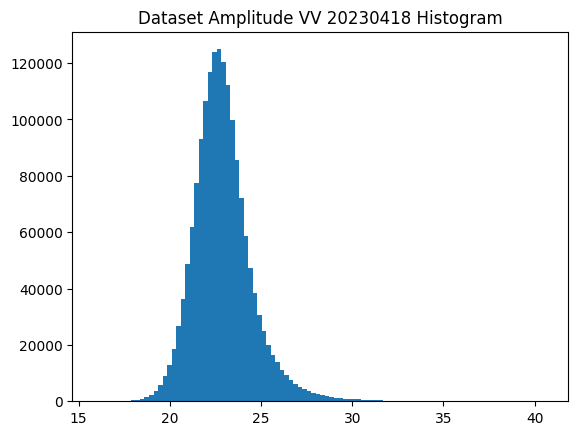

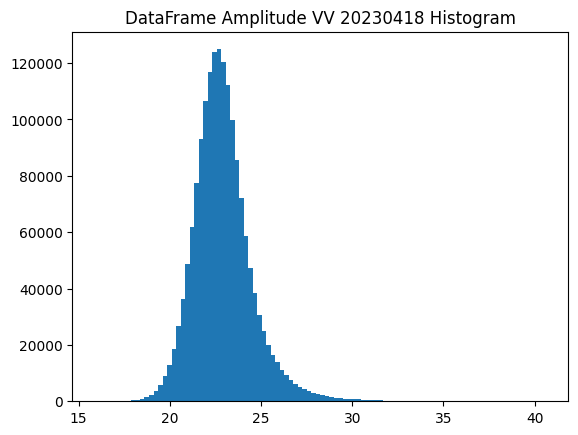

DataFrame dimensions
(1680000, 9)
(1680000, 9) → (1680000, 9)
(1680000, 9) → (1385065, 9)
['Amplitude_VV', 'Amplitude_VH', 'S2_Red', 'S2_Green', 'S2_Blue', 'NDVI', 'NBR', 'RVI']
(1385065, 8)
(1385065,)


In [ ]:
# Data Loading
dataset_name = "Penedes_datastack_final.tif"
folder = '/content/drive/MyDrive/AI4EO Laboratory/'
fullpath = folder + dataset_name

with rasterio.open(fullpath) as dataset:
    dataset_data = dataset.read()
    bands = dataset.descriptions

# Auxiliar Function to clean nan rows and cols
def clean_nan_rows_cols(stack):
    nan_rows = np.all(np.isnan(stack), axis=(0, 2))
    nan_cols = np.all(np.isnan(stack), axis=(0, 1))

    cleaned_stack = stack[:, ~nan_rows, :]
    cleaned_stack = cleaned_stack[:, :, ~nan_cols]

    return cleaned_stack

# Clean nan rows and cols
dataset_data_no_nans = clean_nan_rows_cols(dataset_data)

# Auxiliar DF Generation Function
def data_frame_from_data_generator(dataset, area, bands_names, bands_index, train_flag = False):
  # Bands selection to train the model
  training_stack_full = dataset[bands_index, :, :]

  # Data
  training_stack_sub_area = training_stack_full[:, area[0][0]:area[0][1], area[1][0]:area[1][1]]
  height, width = training_stack_sub_area.shape[1], training_stack_sub_area.shape[2]

  # Define a DataFrame with the data for the model
  df_training = pd.DataFrame(training_stack_sub_area.reshape(len(bands_index), -1).T, columns=bands_names)
  # Define an index as a row-col ID
  row_ID, col_ID = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")
  df_training["row_ID"] = row_ID.flatten()
  df_training["col_ID"] = col_ID.flatten()
  df_training.set_index(['row_ID', 'col_ID'], inplace=True)

  # Check that the data from the dataset is correct in the DataFrame
  plt.figure()
  plt.hist(df_training['Amplitude_VV'].values, bins=100)
  plt.title("Dataset Amplitude VV 20230418 Histogram")
  plt.show()

  plt.figure()
  plt.hist(training_stack_sub_area[0,:,:].flatten(), bins=100)
  plt.title("DataFrame Amplitude VV 20230418 Histogram")
  plt.show()

  print("DataFrame dimensions")
  print(df_training.shape)

  if train_flag:
    # Filter nans
    df_training_no_nans = clean_nan_rows(df_training)
    print(df_training.shape, "→", df_training_no_nans.shape)
    # Filter outliers
    df_training_no_nans_filtered = filter_outliers(df_training_no_nans)
    print(df_training_no_nans.shape, "→", df_training_no_nans_filtered.shape)

    df_training = df_training_no_nans_filtered

  return df_training, height, width

# Functions to clean the DataFrame
def clean_nan_rows(df):
    df_cleaned = df.dropna(how="all")
    df_cleaned = df_cleaned.fillna(0)
    df_cleaned = df_cleaned[~(df_cleaned.eq(0).all(axis=1))]

    return df_cleaned

def filter_outliers(df, lower_percentile=2, upper_percentile=98):
    df_filtered = df.copy()
    columns_to_exclude = ['row_ID', 'col_ID', 'Land_Cover']
    for col in df.columns:
        if col not in columns_to_exclude:
          lower_bound = np.percentile(df[col], lower_percentile)
          upper_bound = np.percentile(df[col], upper_percentile)
          df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]

    return df_filtered

# Generate the Training DF
model_Penedes_bands = ['Amplitude_VV_20230418', 'Amplitude_VH_20230418', 'S2_Red_20230420', 'S2_Green_20230420', 'S2_Blue_20230420', 'NDVI_20230420',
                       'NBR_20230420', 'RVI_20230418', 'Land_Cover']

model_bands_idx = [bands.index(band) for band in model_Penedes_bands]
model_Penedes_bands_generic = [re.sub(r'_\d{8}$', '', name) for name in model_Penedes_bands]
training_Penedes_bands_generic = model_Penedes_bands_generic[:-1]

all_area = [[400, 1200], [100, 2200]]
data_df, height_sub_area, width_sub_area = data_frame_from_data_generator(dataset_data_no_nans, all_area, model_Penedes_bands_generic, model_bands_idx, True)

# Auxiliar Model Training Function
def model_training(df, X_bands, y_bands, model_type):
  print(X_bands)
  # Select the specific bands
  X = df[X_bands]
  y = df[y_bands]
  print(X.shape)
  print(y.shape)

  # Select the model
  if model_type == "Decision Tree":
    model = DecisionTreeClassifier(max_depth = 10)
  elif model_type == "Random Forest":
    model = RandomForestClassifier(n_estimators=25,
                              max_depth=5,
                              random_state=0)
  elif model_type == "MLP":
      model = Pipeline([
          ('scaler', StandardScaler()),
          ('mlp', MLPClassifier(hidden_layer_sizes=(10,),
                                random_state=0,
                                solver='lbfgs',
                                alpha=0.1))
      ])

  model.fit(X, y)
  return model

# Train Model
rf_clf = model_training(data_df, training_Penedes_bands_generic, 'Land_Cover', "Random Forest")

Now we will plot the feature importance, according the random forest selected features.

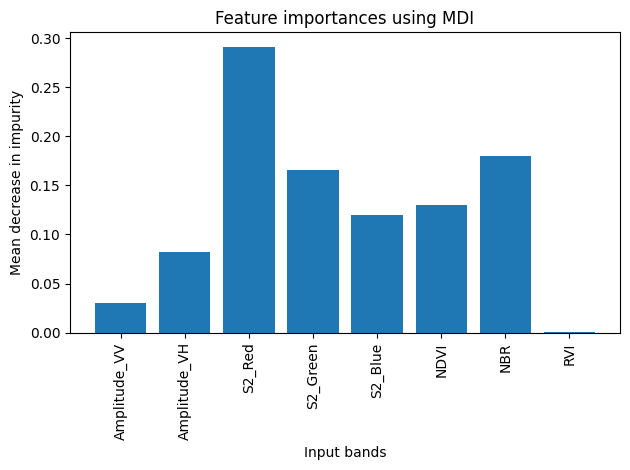

In [ ]:
importances = rf_clf.feature_importances_

fig, ax = plt.subplots()
ax.bar(range(len(importances)), importances)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticks(range(len(importances)), training_Penedes_bands_generic, rotation='vertical')
ax.set_xlabel("Input bands")
fig.tight_layout()

An auxiliar function to generate DataFrames, this time from xarray, is defined.

In [ ]:
def generate_dataframe_from_xarray(fire_datastack, land_cover_layer, Change_Band_data, rgb_20210826, rgb_20210826_2, rgb_20220103, datastack_variables, area):

  fire_datastack_specific = fire_datastack[datastack_variables].isel(
      lat=slice(area[0][0], area[0][1]),
      lon=slice(area[1][0], area[1][1])
  )

  land_cover_layer_specific = land_cover_layer.isel(
      lat=slice(area[0][0], area[0][1]),
      lon=slice(area[1][0], area[1][1])
  )

  plot_landcover(land_cover_layer_specific)

  Change_Band_data_specific = Change_Band_data.isel(
      lat=slice(area[0][0], area[0][1]),
      lon=slice(area[1][0], area[1][1])
  )

  plot_data(Change_Band_data_specific)

  rgb_20210826_specific = rgb_20210826[area[0][0]:area[0][1], area[1][0]:area[1][1]]
  rgb_20210826_specific = rgb_20210826[area[0][0]:area[0][1], area[1][0]:area[1][1]]
  rgb_20220103_specific = rgb_20220103[area[0][0]:area[0][1], area[1][0]:area[1][1]]

  height = area[0][1] - area[0][0]
  width = area[1][1] - area[1][0]

  df_fire = fire_datastack_specific.to_dataframe().reset_index()
  df_fire.drop(columns=['lon', 'lat'], inplace=True)

  return df_fire, height, width, land_cover_layer_specific, Change_Band_data_specific, rgb_20210826_specific, rgb_20210826_specific, rgb_20220103_specific

<xarray.Dataset> Size: 99MB
Dimensions:                   (lat: 558, lon: 1226)
Coordinates:
  * lat                       (lat) float64 4kB -0.5 -1.5 -2.5 ... -556.5 -557.5
  * lon                       (lon) float64 10kB 0.5 1.5 ... 1.224e+03 1.226e+03
Data variables: (12/36)
    Amplitude_VV_20210823     (lat, lon) float32 3MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Amplitude_VV_20220108     (lat, lon) float32 3MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Amplitude_VH_20210823     (lat, lon) float32 3MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Amplitude_VH_20220108     (lat, lon) float32 3MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    VH_VV_rate_20210823       (lat, lon) float32 3MB ...
    VH_VV_rate_20220108       (lat, lon) float32 3MB ...
    ...                        ...
    NDSI_20210826             (lat, lon) float32 3MB ...
    NDSI_20220103             (lat, lon) float32 3MB ...
    Land_Cover                (lat, lon) float32 3MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Change_Band               (lat, lon) float32 3MB 

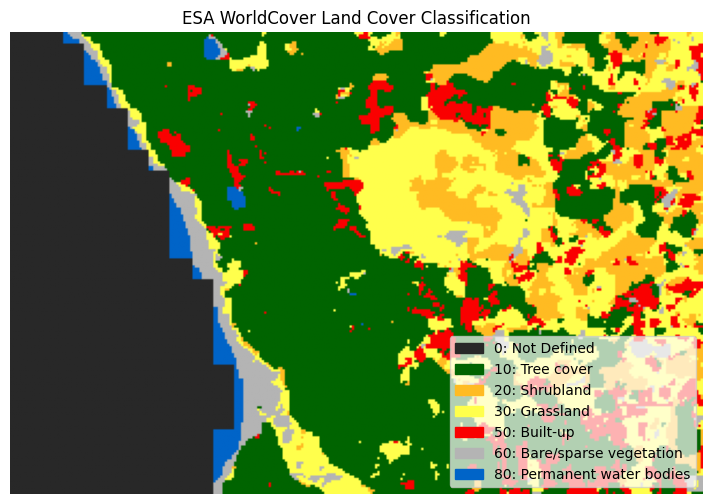

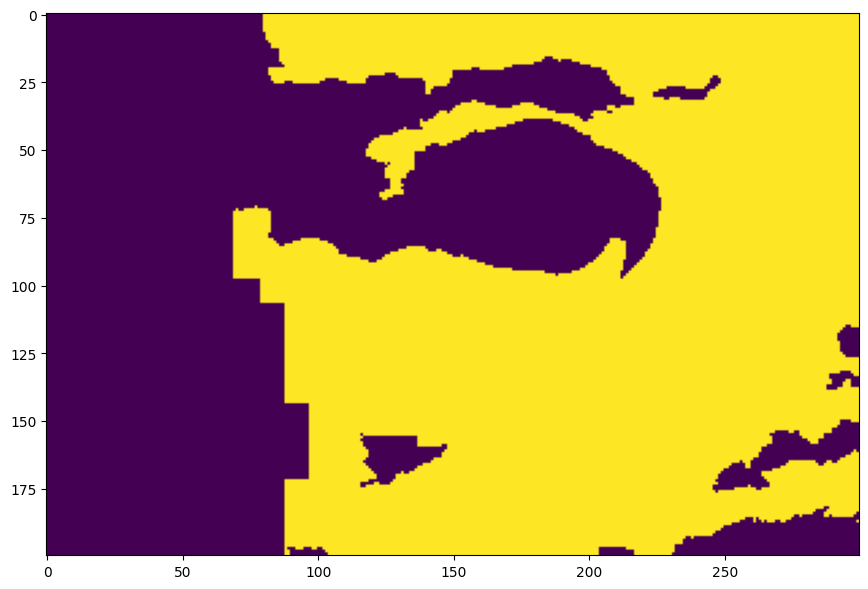

In [ ]:
area = ((200, 400), (200, 500))
print(fire_datastack)
df_fire, height, width, land_cover_layer_specific, Change_Band_data_specific, rgb_20210826_specific, rgb_20210826_specific, rgb_20220103_specific = generate_dataframe_from_xarray(fire_datastack, land_cover_layer, Change_Band_layer, rgb_20210826, rgb_20210826, rgb_20220103, datastack_variables, area)

In [ ]:
# Auxiliar Function to Test and Validate the Model
def model_testing_and_validating(df, X_bands, y_bands, model, validation_data, class_mapping, original_height, original_width, rgb_data, ba_data):
  # Select the specific bands
  X = df[X_bands]
  y = df[y_bands]
  print(f"X data shape: {X.shape}")
  print(f"y data shape: {y.shape}\n")

  # Fill nans
  X = X.fillna(0)
  y = y.fillna(0)

  # Rename columns so they have generic names
  X.columns = [re.sub(r'_\d{8}$', '', col) for col in X.columns]

  print(X.columns)

  # Make the prediction
  y_pred = model.predict(X)
  print(f"y data pred shape: {y_pred.shape}\n")

  # Acuracy
  ovAcc_model = accuracy_score(validation_data.values.ravel(), y_pred)
  print("Accuracy: %.2f%%\n" % (100*ovAcc_model))

  # Confusion Matrix
  class_names = [class_mapping[c] for c in np.unique(validation_data) if c in class_mapping]

  # Images Representation
  Y_im_model = y_pred.reshape((original_height, original_width))
  print(Y_im_model.shape)

  fig, axs = plt.subplots(1, 4, figsize=(12, 6))

  im0 = axs[0].imshow(rgb_data)
  axs[0].set_title("Optical RGB image")
  axs[0].axis("off")

  plot_landcover(validation_data, ax=axs[1], title="Ground Reference LC")

  plot_landcover(Y_im_model, ax=axs[2], title="Old Acquisitions LC Prediction")

  im3 = axs[3].imshow(ba_data)
  axs[3].set_title("Burn Area layer")
  axs[3].axis("off")

  plt.tight_layout()
  plt.show()

  return Y_im_model

Finally a function to test and validate the model is defined to be used with the DataFrame we generated previously. We define three cases, to predict with the older acquisitions, to predict with the acquisitions before the fire and to predict with the acquisitions after the fire. We specifiy the variables in each prediction according to these three cases.

Prediction of the Old Aquisitions
X data shape: (60000, 8)
y data shape: (60000,)

Index(['Amplitude_VV', 'Amplitude_VH', 'S2_Red', 'S2_Green', 'S2_Blue', 'NDVI',
       'NBR', 'RVI'],
      dtype='object')
y data pred shape: (60000,)

Accuracy: 36.23%

(200, 300)


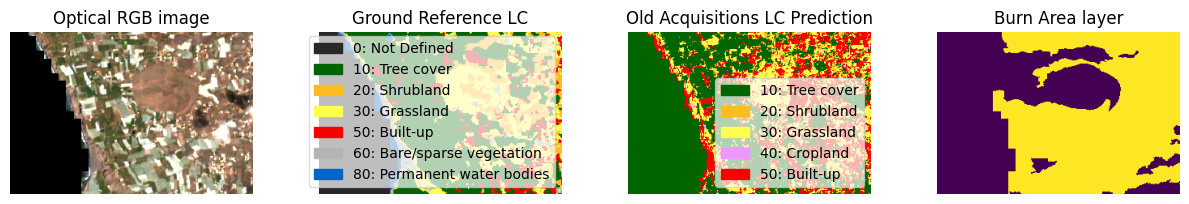

In [ ]:
print("Prediction of the Old Aquisitions")
old_variables = ['Amplitude_VV_20210823', 'Amplitude_VH_20210823', 'S2_Red_20210826', 'S2_Green_20210826', 'S2_Blue_20210826', 'NDVI_20210826', 'NBR_20210826', 'RVI_20210823']
Y_im_rf = model_testing_and_validating(df_fire, old_variables, "Land_Cover", rf_clf, land_cover_layer_specific, class_mapping, height, width, rgb_20210826_specific, Change_Band_data_specific)



* What is the model predicting?
* Is the model performing good? Why?
* What should be changed in this case?



Prediction of the Pre-Fire Acquisitions
X data shape: (60000, 8)
y data shape: (60000,)

Index(['Amplitude_VV', 'Amplitude_VH', 'S2_Red', 'S2_Green', 'S2_Blue', 'NDVI',
       'NBR', 'RVI'],
      dtype='object')
y data pred shape: (60000,)

Accuracy: 36.23%

(200, 300)


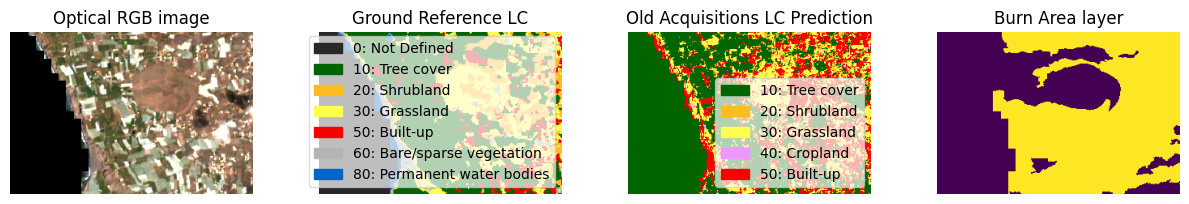

In [ ]:
print("Prediction of the Pre-Fire Acquisitions")
pre_fire_variables = ['Amplitude_VV_20210823', 'Amplitude_VH_20210823', 'S2_Red_20210826', 'S2_Green_20210826', 'S2_Blue_20210826', 'NDVI_20210826', 'NBR_20210826', 'RVI_20210823']
Y_im_rf = model_testing_and_validating(df_fire, pre_fire_variables, "Land_Cover", rf_clf, land_cover_layer_specific, class_mapping, height, width, rgb_20210826_specific, Change_Band_data_specific)

* What is the model predicting?
* Is the model performing good? Why?
* What should be changed in this case?

Prediction of the Post-Fire Acquisition
X data shape: (60000, 8)
y data shape: (60000,)

Index(['Amplitude_VV', 'Amplitude_VH', 'S2_Red', 'S2_Green', 'S2_Blue', 'NDVI',
       'NBR', 'RVI'],
      dtype='object')
y data pred shape: (60000,)

Accuracy: 37.62%

(200, 300)


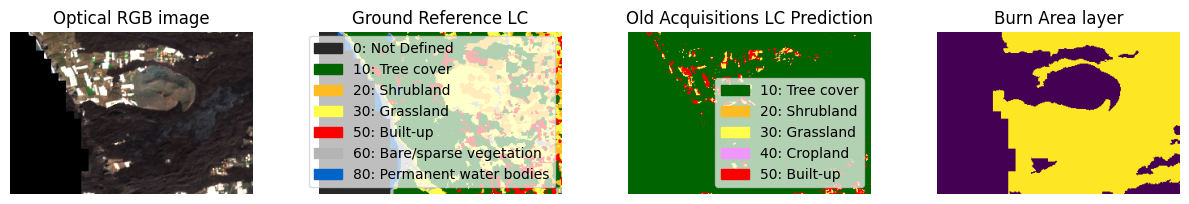

In [ ]:
print("Prediction of the Post-Fire Acquisition")
post_fire_variables = ['Amplitude_VV_20220108', 'Amplitude_VH_20220108', 'S2_Red_20220103', 'S2_Green_20220103', 'S2_Blue_20220103', 'NDVI_20220103', 'NBR_20220103', 'RVI_20220108']
Y_im_rf = model_testing_and_validating(df_fire, post_fire_variables, "Land_Cover", rf_clf, land_cover_layer_specific, class_mapping, height, width, rgb_20220103_specific, Change_Band_data_specific)

* What is the model predicting?
* Is the model performing good? Why?
* What should be changed in this case?

## ML Model to Predict Burn Areas

Now we will train a ML model to prdict if an area is burned or not.

In [ ]:
def data_frame_from_data_generator(dataset, rgb, Change_Band_layer, num_samples, bands, bands_generic):
  # Bands selection to train the model
  training_stack_full = dataset[bands]

  df_training = extract_samples(Change_Band_layer, training_stack_full, bands, bands_generic, num_samples)
  # Filter nans
  df_training_no_nans = clean_nan_rows(df_training)
  print(df_training.shape, "→", df_training_no_nans.shape)
  # Filter outliers
  df_training_no_nans_filtered = filter_outliers(df_training_no_nans)
  print(df_training_no_nans.shape, "→", df_training_no_nans_filtered.shape)

  return df_training_no_nans_filtered

###############################################################################
# Function to select specific land cover points
def extract_samples(Change_Band_layer, dataset, model_bands, model_bands_generic, samples_per_class=100):
    np.random.seed(42)

    df_train = pd.DataFrame(columns=model_bands_generic + ['row', 'col', 'label'])
    selected_mask = np.zeros_like(Change_Band_layer, dtype=bool)

    band_map = {generic: full for generic, full in zip(model_bands_generic, model_bands)}

    for class_value in [0, 1]:
        indices = np.argwhere(Change_Band_layer.values == class_value)

        if len(indices) == 0:
            continue

        if len(indices) >= samples_per_class:
            selected_indices = indices[np.random.choice(len(indices), samples_per_class, replace=False)]
        else:
            selected_indices = indices

        for row, col in selected_indices:
            sample_dict = {'row': row, 'col': col, 'label': class_value}
            for generic_band in model_bands_generic:
                full_band = band_map.get(generic_band)

                if full_band:
                    try:
                        val = dataset[full_band].isel(lat=row, lon=col).item()
                    except Exception as e:
                        print(f"Error accessing {full_band} at ({row},{col}): {e}")
                        val = np.nan
                else:
                    val = np.nan

                sample_dict[generic_band] = val

            df_train.loc[len(df_train)] = sample_dict
            selected_mask[row, col] = True

    return df_train

# Functions to clean the DataFrame
def clean_nan_rows(df):
    df_cleaned = df.dropna(how="all")
    df_cleaned = df_cleaned.fillna(0)

    return df_cleaned

def filter_outliers(df, lower_percentile=2, upper_percentile=98):
    df_filtered = df.copy()
    columns_to_exclude = ['row_ID', 'col_ID', 'Land_Cover', 'Change_Band']
    for col in df.columns:
        if col not in columns_to_exclude:
          lower_bound = np.percentile(df[col], lower_percentile)
          upper_bound = np.percentile(df[col], upper_percentile)
          df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]

    return df_filtered

Very similar as before we first define the DataFrame to train the model. Now with the specific variables and number of samples of the burn area layer.

In [ ]:
model_fires_bands = ['Amplitude_VV_20220108', 'Amplitude_VH_20220108', 'S2_Red_20220103', 'S2_Green_20220103', 'S2_Blue_20220103', 'NDVI_20220103', 'NBR_20220103', 'Land_Cover', 'Change_Band', 'RVI_20220108']
model_fires_bands_generic = [re.sub(r'_\d{8}$', '', name) for name in model_fires_bands]
training_fires_bands_generic = [var for var in model_fires_bands_generic if var not in ["Change_Band"]]

num_samples = 2000
df_train_fire_area = data_frame_from_data_generator(fire_datastack, rgb_20220103, Change_Band_layer, num_samples, model_fires_bands, model_fires_bands_generic)

(4000, 13) → (4000, 13)
(4000, 13) → (3377, 13)


We train the model to predict Burn Areas, also using a Random Forest.

* Try to change the classifier and/or modify its parameter to see what is obtained at the end with the predicition.

In [ ]:
#mlp_clf = model_training(df_train_fire_area, training_fires_bands_generic, "Change_Band", "MLP")
mlp_clf = model_training(df_train_fire_area, training_fires_bands_generic, "Change_Band", "Decision Tree")
#mlp_clf = model_training(df_train_fire_area, training_fires_bands_generic, "Change_Band", "Random Forest")

['Amplitude_VV', 'Amplitude_VH', 'S2_Red', 'S2_Green', 'S2_Blue', 'NDVI', 'NBR', 'Land_Cover', 'RVI']
(3377, 9)
(3377,)


In [ ]:
# Auxiliar Function to Test and Validate the Model
def model_testing_and_validating(df, X_bands, y_bands, model, validation_data, original_height, original_width, rgb_data):
  # Select the specific bands
  X = df[X_bands]
  y = df[y_bands]
  print(f"X data shape: {X.shape}")
  print(f"y data shape: {y.shape}\n")

  # Fill nans
  X = X.fillna(0)
  y = y.fillna(0)

  # Rename columns so they have generic names
  X.columns = [re.sub(r'_\d{8}$', '', col) for col in X.columns]

  # Make the prediction
  y_pred = model.predict(X)
  print(f"y data pred shape: {y_pred.shape}\n")

  # Accuracy
  ovAcc_model = accuracy_score(validation_data.values.ravel(), y_pred)
  print("Accuracy: %.2f%%\n" % (100 * ovAcc_model))

  # Confusion Matrix
  cm = confusion_matrix(validation_data.values.ravel(), y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Burned', 'Burned'])
  disp.plot(cmap='Blues', values_format='d')
  plt.title("Confusion Matrix")
  plt.show()

  # Images Representation
  Y_im_model = y_pred.reshape((original_height, original_width))
  print(Y_im_model.shape)

  fig, axs = plt.subplots(1, 3, figsize=(12, 6))

  im0 = axs[0].imshow(rgb_data)
  axs[0].set_title("Optical RGB image")
  axs[0].axis("off")

  im1 = axs[1].imshow(validation_data)
  axs[1].set_title("Burn Area layer")
  axs[1].axis("off")
  fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

  im2 = axs[2].imshow(Y_im_model)
  axs[2].set_title("Model Classification")
  axs[2].axis("off")
  fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

  plt.tight_layout()
  plt.show()

  return Y_im_model

X data shape: (60000, 9)
y data shape: (60000,)

y data pred shape: (60000,)

Accuracy: 95.94%



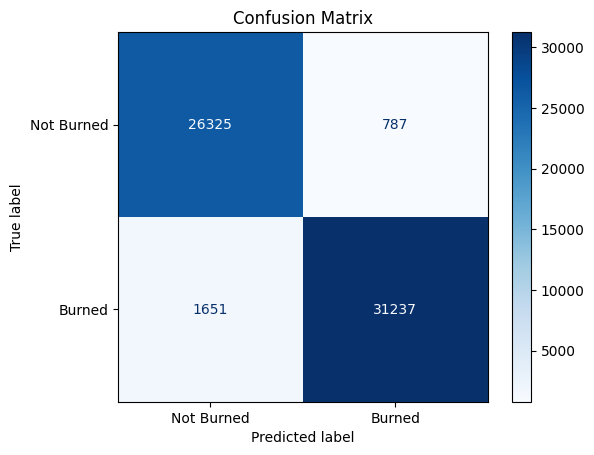

(200, 300)


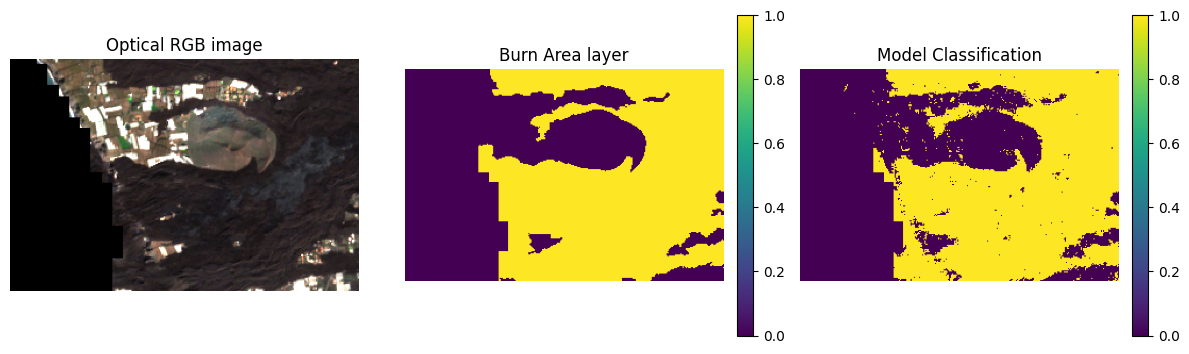

In [ ]:
Change_Band_variables = ['Amplitude_VV_20220108', 'Amplitude_VH_20220108', 'S2_Red_20220103', 'S2_Green_20220103', 'S2_Blue_20220103', 'NDVI_20220103', 'NBR_20220103', 'Land_Cover', 'RVI_20220108']
_ = model_testing_and_validating(df_fire, Change_Band_variables, "Change_Band", mlp_clf, Change_Band_data_specific, height, width, rgb_20220103_specific)

X data shape: (60000, 9)
y data shape: (60000,)

y data pred shape: (60000,)

Accuracy: 93.85%



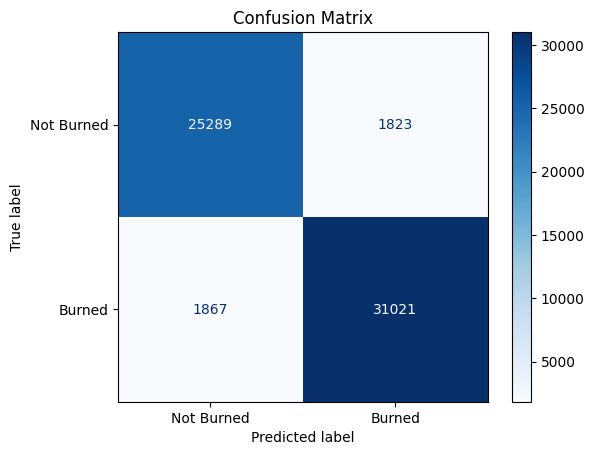

(200, 300)


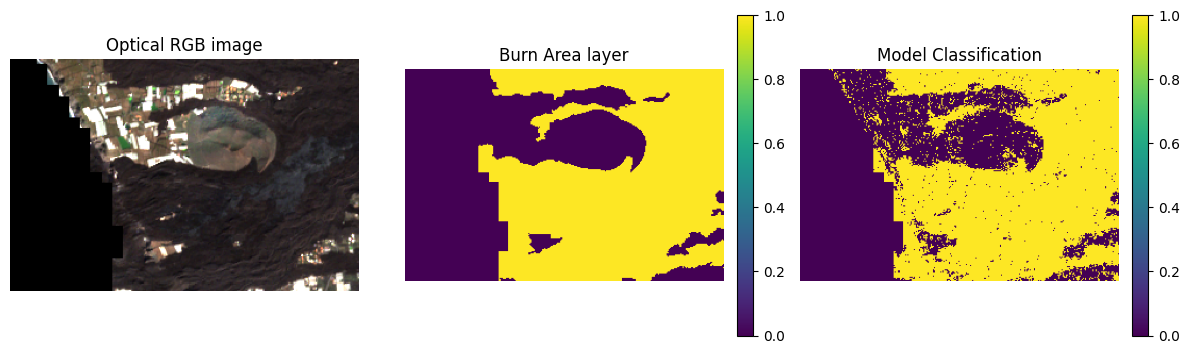

In [ ]:
Change_Band_variables = ['Amplitude_VV_20220108', 'Amplitude_VH_20220108', 'S2_Red_20220103', 'S2_Green_20220103', 'S2_Blue_20220103', 'NDVI_20220103', 'NBR_20220103', 'Land_Cover', 'RVI_20220108']
_ = model_testing_and_validating(df_fire, Change_Band_variables, "Change_Band", mlp_clf, Change_Band_data_specific, height, width, rgb_20220103_specific)

Finally we test and validate the model.

X data shape: (60000, 9)
y data shape: (60000,)

y data pred shape: (60000,)

Accuracy: 95.36%



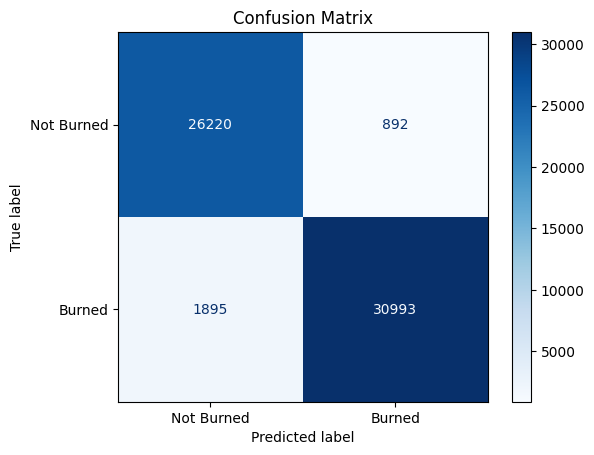

(200, 300)


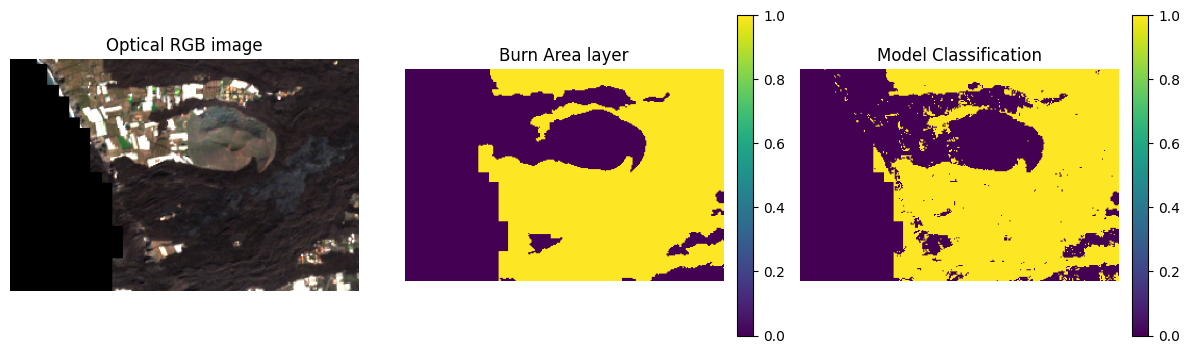

In [ ]:
Change_Band_variables = ['Amplitude_VV_20220108', 'Amplitude_VH_20220108', 'S2_Red_20220103', 'S2_Green_20220103', 'S2_Blue_20220103', 'NDVI_20220103', 'NBR_20220103', 'Land_Cover', 'RVI_20220108']
_ = model_testing_and_validating(df_fire, Change_Band_variables, "Change_Band", mlp_clf, Change_Band_data_specific, height, width, rgb_20220103_specific)

* How are the results? Is the model performing correctly?
* What can we do to obtain better results?
* What other changes could be made to better predict burn areas?